In [81]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, LearningRateScheduler
import time

PLOT=True
# PLOT=False

SEQ_LEN=40
OUTPUT_LEN=5
EPOCHS=10

In [82]:
url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
df.drop("volume", 1, inplace=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_index('date', inplace=True)

df.head()

,open,high,low,close
date,,,,
2018-01-01 17:00:00,1.20037,1.20100,1.20037,1.20100
2018-01-01 17:01:00,1.20083,1.20095,1.20017,1.20030
2018-01-01 17:02:00,1.20035,1.20043,1.20035,1.20043
2018-01-01 17:03:00,1.20041,1.20050,1.20031,1.20046
2018-01-01 17:04:00,1.20049,1.20049,1.20046,1.20048


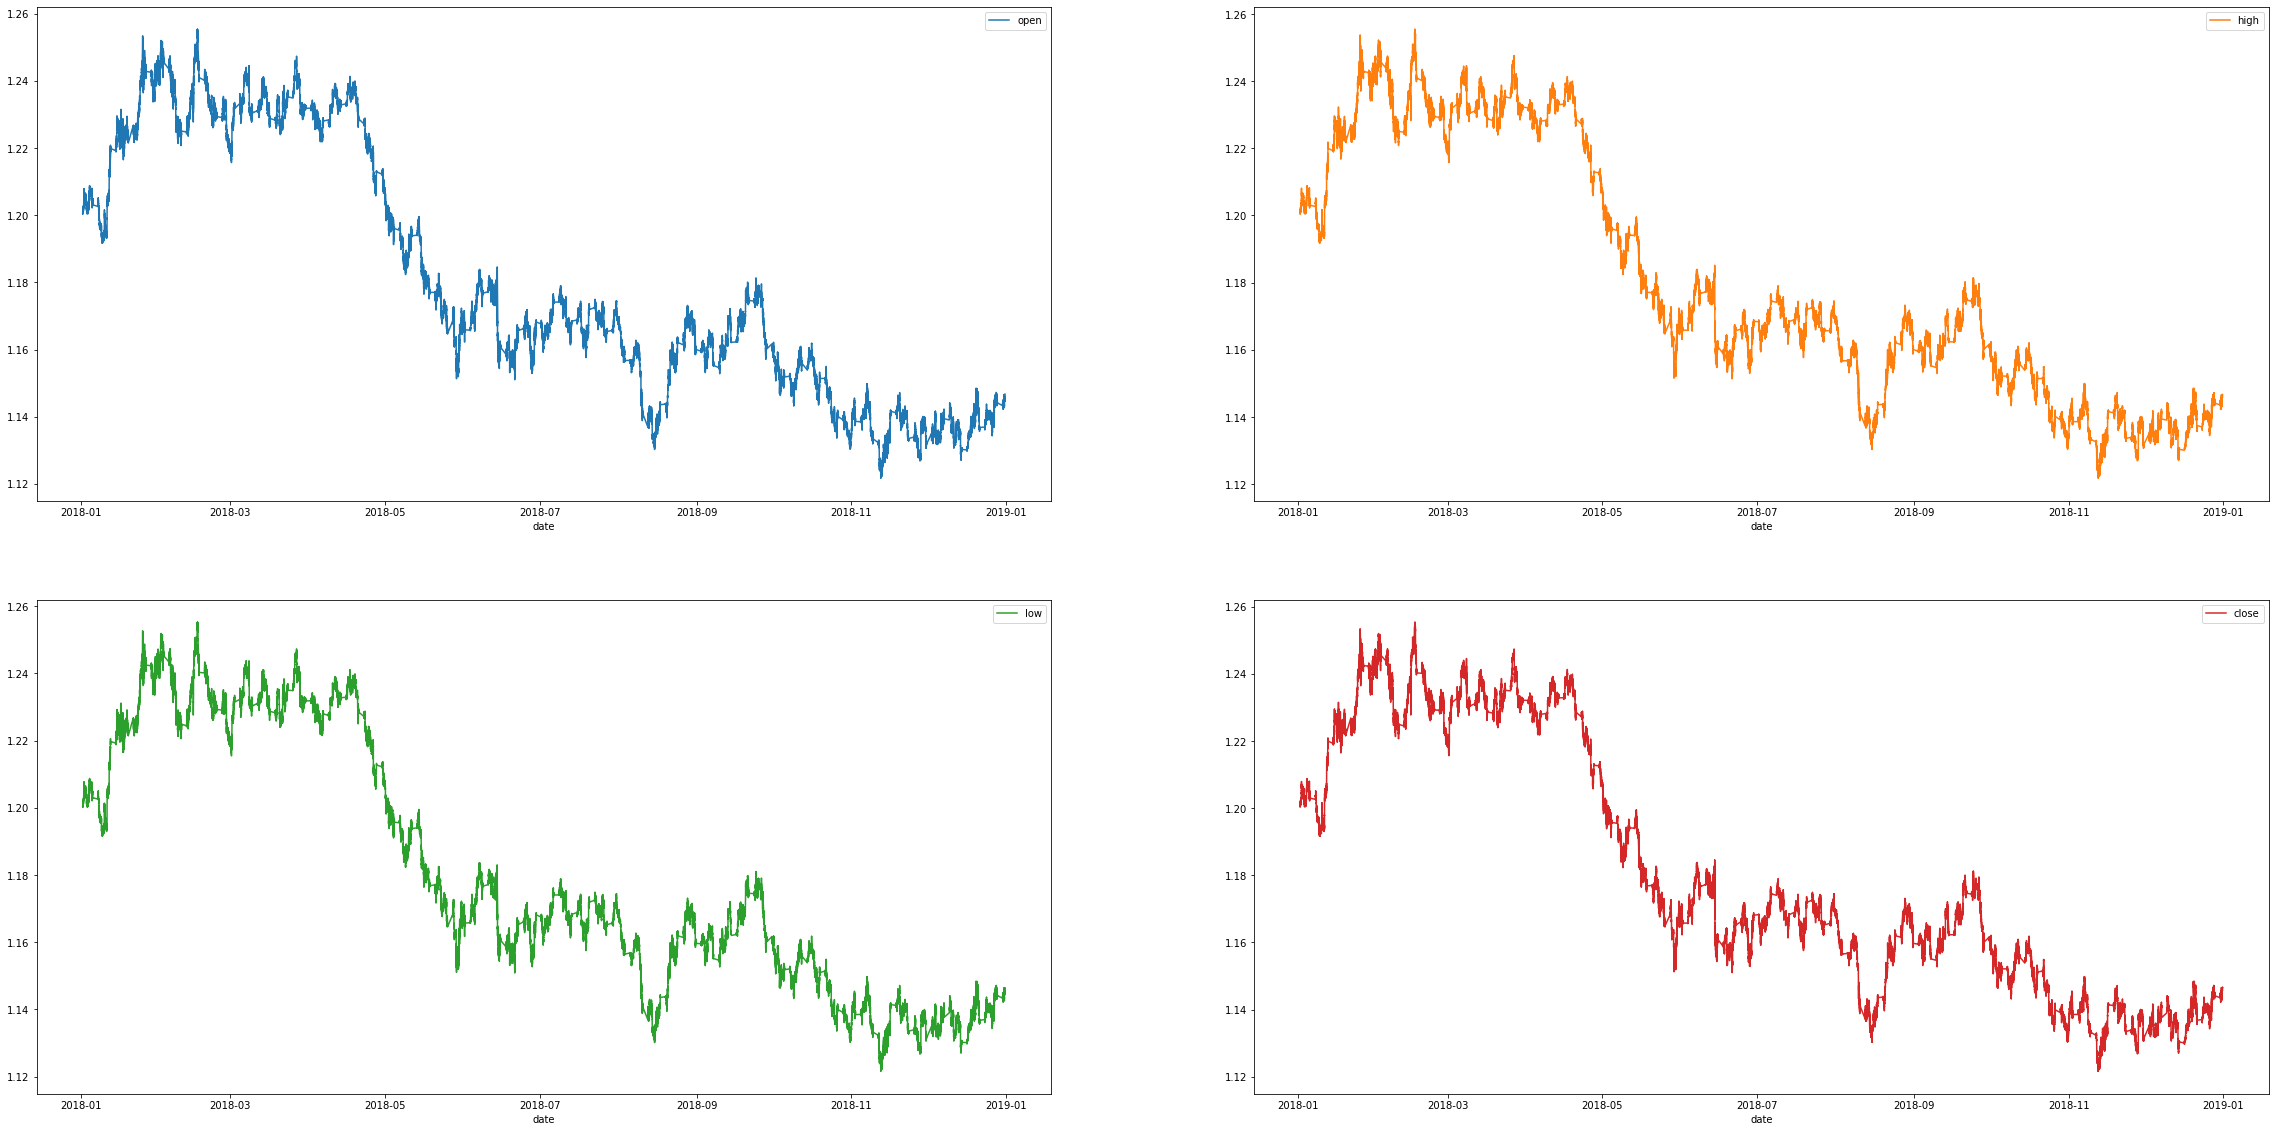

In [83]:
if PLOT:
    df.plot(subplots=True, layout=(2, 2), figsize=(40, 20), sharex=False)

In [84]:
data_set = df.iloc[:, 2:3].values #close
print(data_set)

[[1.20037]
 [1.20017]
 [1.20035]
 ...
 [1.1464 ]
 [1.14639]
 [1.14635]]


In [85]:
print(data_set.shape)

(372607, 1)


In [86]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(data_set)

In [87]:
X_train = []
y_train = []
for i in range(SEQ_LEN, training_set_scaled.size-20):
    X_train.append(training_set_scaled[i-SEQ_LEN:i, 0])
    y_train.append(np.array(training_set_scaled[i+1:i+1+OUTPUT_LEN, 0]))
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train[0])
print(y_train[0])

[0.58947132 0.58797577 0.58932177 0.58902266 0.59014432 0.59029388
 0.58909744 0.58872355 0.5902191  0.59238765 0.59238765 0.59298587
 0.59261198 0.59268676 0.59246242 0.58939655 0.5895461  0.5895461
 0.58969566 0.58977043 0.58999477 0.59006954 0.59006954 0.59029388
 0.59006954 0.59051821 0.58984521 0.58984521 0.59149032 0.59141554
 0.59178943 0.59193898 0.59238765 0.59193898 0.59328498 0.59590219
 0.59635086 0.59635086 0.59664997 0.59650041]
[0.59664997 0.5968743  0.59672474 0.59664997 0.59672474]


In [88]:
X_train = np.reshape(np.asarray(X_train).astype(np.float32), (X_train.shape[0], X_train.shape[1], 1))
print(X_train[0])

[[0.58947134]
 [0.5879758 ]
 [0.5893218 ]
 [0.58902264]
 [0.59014434]
 [0.5902939 ]
 [0.58909744]
 [0.58872354]
 [0.5902191 ]
 [0.5923877 ]
 [0.5923877 ]
 [0.59298587]
 [0.59261197]
 [0.5926868 ]
 [0.5924624 ]
 [0.58939654]
 [0.5895461 ]
 [0.5895461 ]
 [0.58969563]
 [0.58977044]
 [0.5899948 ]
 [0.59006953]
 [0.59006953]
 [0.5902939 ]
 [0.59006953]
 [0.59051824]
 [0.58984524]
 [0.58984524]
 [0.5914903 ]
 [0.5914155 ]
 [0.5917894 ]
 [0.591939  ]
 [0.5923877 ]
 [0.591939  ]
 [0.59328496]
 [0.5959022 ]
 [0.59635085]
 [0.59635085]
 [0.59664994]
 [0.5965004 ]]


In [89]:
print(y_train)

[[0.59664997 0.5968743  0.59672474 0.59664997 0.59672474]
 [0.5968743  0.59672474 0.59664997 0.59672474 0.59672474]
 [0.59672474 0.59664997 0.59672474 0.59672474 0.59777163]
 ...
 [0.18432663 0.18447618 0.18470052 0.18462574 0.18462574]
 [0.18447618 0.18470052 0.18462574 0.18462574 0.18327974]
 [0.18470052 0.18462574 0.18462574 0.18327974 0.1827563 ]]


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [91]:
print(X_train.shape)
print(X_train[0].shape)

(298037, 40, 1)
(40, 1)


In [92]:

print(X_train)

[[[0.3076348 ]
  [0.30606446]
  [0.30479324]
  ...
  [0.31249532]
  [0.31249532]
  [0.31309354]]

 [[0.21857475]
  [0.21909818]
  [0.21752785]
  ...
  [0.21461153]
  [0.21281686]
  [0.21132132]]

 [[0.8656995 ]
  [0.8664473 ]
  [0.8663725 ]
  ...
  [0.87729007]
  [0.87758917]
  [0.8773648 ]]

 ...

 [[0.48216555]
  [0.48246467]
  [0.48224035]
  ...
  [0.48119345]
  [0.48111868]
  [0.48067   ]]

 [[0.36812982]
  [0.3671577 ]
  [0.36708292]
  ...
  [0.36902714]
  [0.36775592]
  [0.36693338]]

 [[0.6427877 ]
  [0.64331114]
  [0.6437598 ]
  ...
  [0.6438346 ]
  [0.64398414]
  [0.6438346 ]]]


In [93]:
vr=[np.array(x) for x in y_train[:5]]

print(vr[0][0])

# return

0.3136917669931947


In [94]:
model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=30))
model.add(Dropout(0.2))
model.add(Dense(units=OUTPUT_LEN))

opt = Adam(lr=0.001, decay=1e-6)

NAME = f"PRED-{int(time.time())}-OUTPUT_LEN={OUTPUT_LEN}-SEQ_LEN={SEQ_LEN}"  
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME, update_freq=25))
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.0001)


def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    return lr / (epoch*3)  

lr_scheduler_cb=LearningRateScheduler(schedule=scheduler)

model.compile(optimizer=opt,loss='mean_squared_error')

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 40, 50)            10400     
_________________________________________________________________
dropout_16 (Dropout)         (None, 40, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 40, 50)            20200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 40, 50)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)               

In [73]:
model.fit(X_train,y_train,epochs=EPOCHS,batch_size=128,validation_data=(X_test, y_test))

model_file=f"models/{NAME}_model.h5"

model.save(model_file)

score=model.evaluate(X_test, y_test, verbose=1) 

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [74]:
print(NAME)

PRED-1594673880-OUTPUT_LEN=60-SEQ_LEN=300


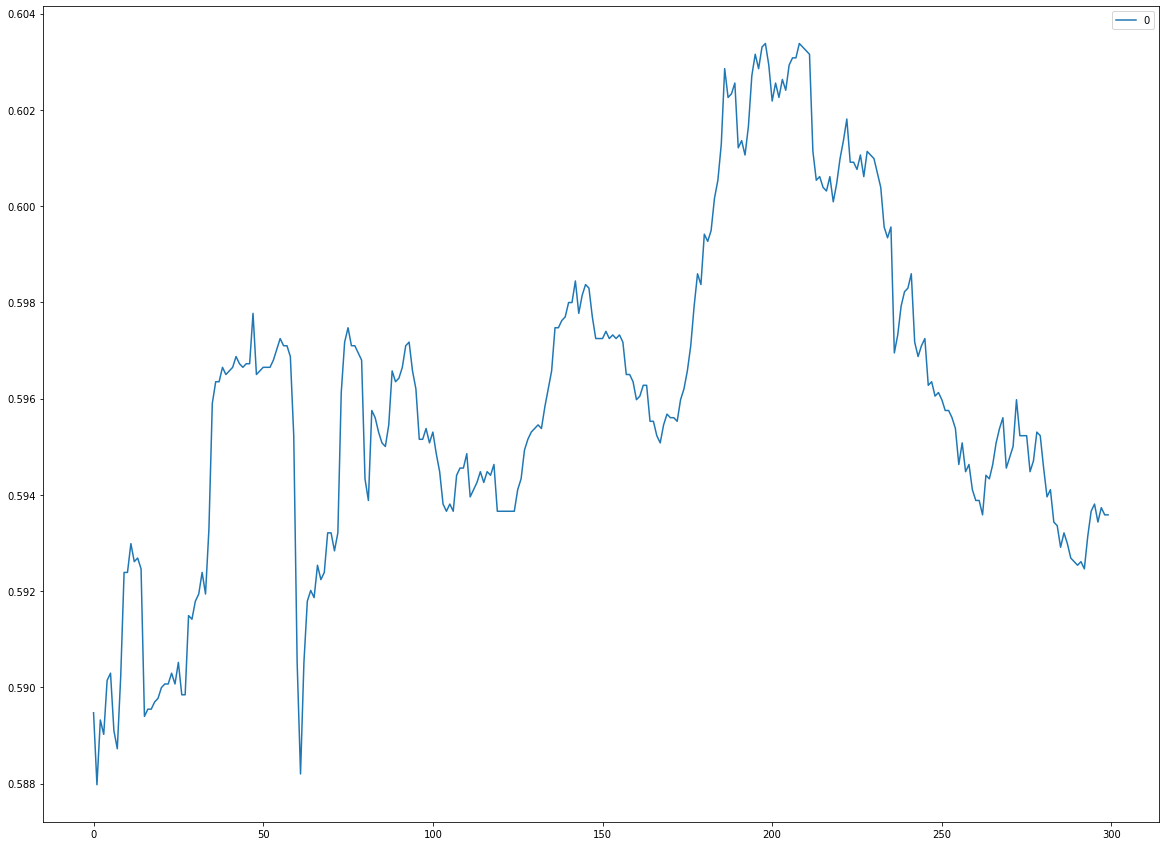

In [75]:
chain_predict = np.array([training_set_scaled[:SEQ_LEN]])
pd.DataFrame(data=chain_predict[0]).plot(figsize=(20, 15), )

In [76]:
output=[]

for i in range(SEQ_LEN,5000):
    if i%100==0 or i==SEQ_LEN:
        print(chain_predict.shape)
    pred_val=model.predict(chain_predict)
    output.append(pred_val)
    concatenated=np.concatenate((np.array([x[0] for x in chain_predict[0][:SEQ_LEN-OUTPUT_LEN]]), pred_val[0]))
    chain_predict=np.array([concatenated.reshape(-1,1)])

(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)
(1, 300, 1)


In [77]:
print(model.predict(chain_predict))
print()
print(np.array([x[0] for x in output]).flatten())
output=np.array([x[0] for x in output]).flatten()

[[ 6.69464089e-06 -8.90348747e-06  2.19692083e-06  1.75875666e-05
  -1.27822123e-05 -5.72468389e-06 -1.13412216e-05  1.41914347e-06
   3.32039889e-07  1.44772475e-05  1.08840886e-05  4.19397384e-06
   5.15567854e-06 -9.40955306e-06 -2.59477520e-06  3.55980155e-05
   5.66120616e-06  2.98849000e-06  4.95096310e-06  1.33326166e-05
  -4.45818796e-06  1.48279823e-05 -2.14750489e-05  6.13190559e-06
  -1.33136118e-05 -1.57260165e-05  6.36772882e-07  1.16559604e-05
   9.95111441e-06  4.13997759e-06 -2.82714136e-05  3.35596724e-07
  -2.35970419e-05  7.43927558e-06 -2.40030658e-05 -2.52766367e-05
  -7.28249279e-06 -8.47577849e-06  8.99386578e-06  1.08581617e-05
  -1.03733209e-05 -1.72202272e-05 -5.69412214e-06 -3.31532715e-06
  -2.16336321e-06 -1.63791574e-05 -2.65239760e-05  9.28214740e-06
  -8.77139701e-06  6.13986003e-06 -1.20770974e-05 -4.54101468e-07
   1.89959087e-06  1.21367802e-05 -3.03748220e-06  5.80922779e-06
  -6.30576869e-06  2.18446166e-06  8.40079792e-06 -4.07268044e-06]]

[ 3.744

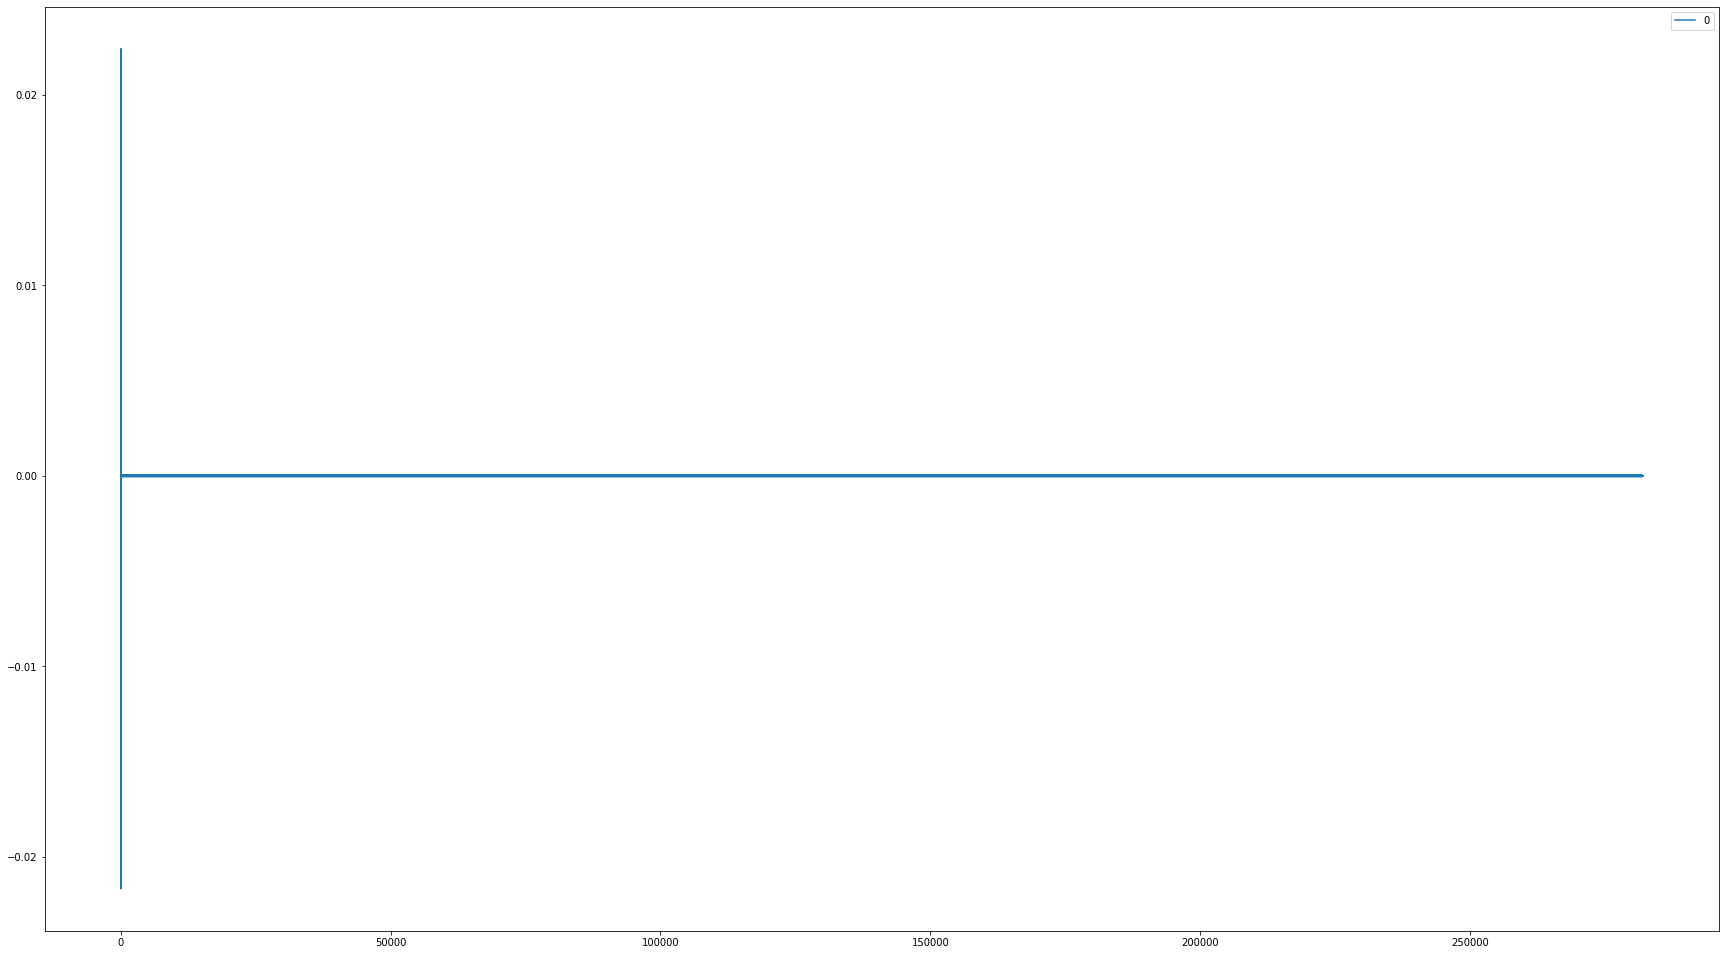

In [78]:
npoutput=sc.inverse_transform(np.array(output).reshape(-1,1))
npoutput=np.array(output).reshape(1,-1)[0]


pd.DataFrame(data=npoutput).plot(figsize=(30, 17))

In [79]:
print(npoutput)

[ 3.7449780e-03  2.2430364e-02  1.4438852e-02 ...  2.1844553e-06
  8.4007970e-06 -4.0726777e-06]


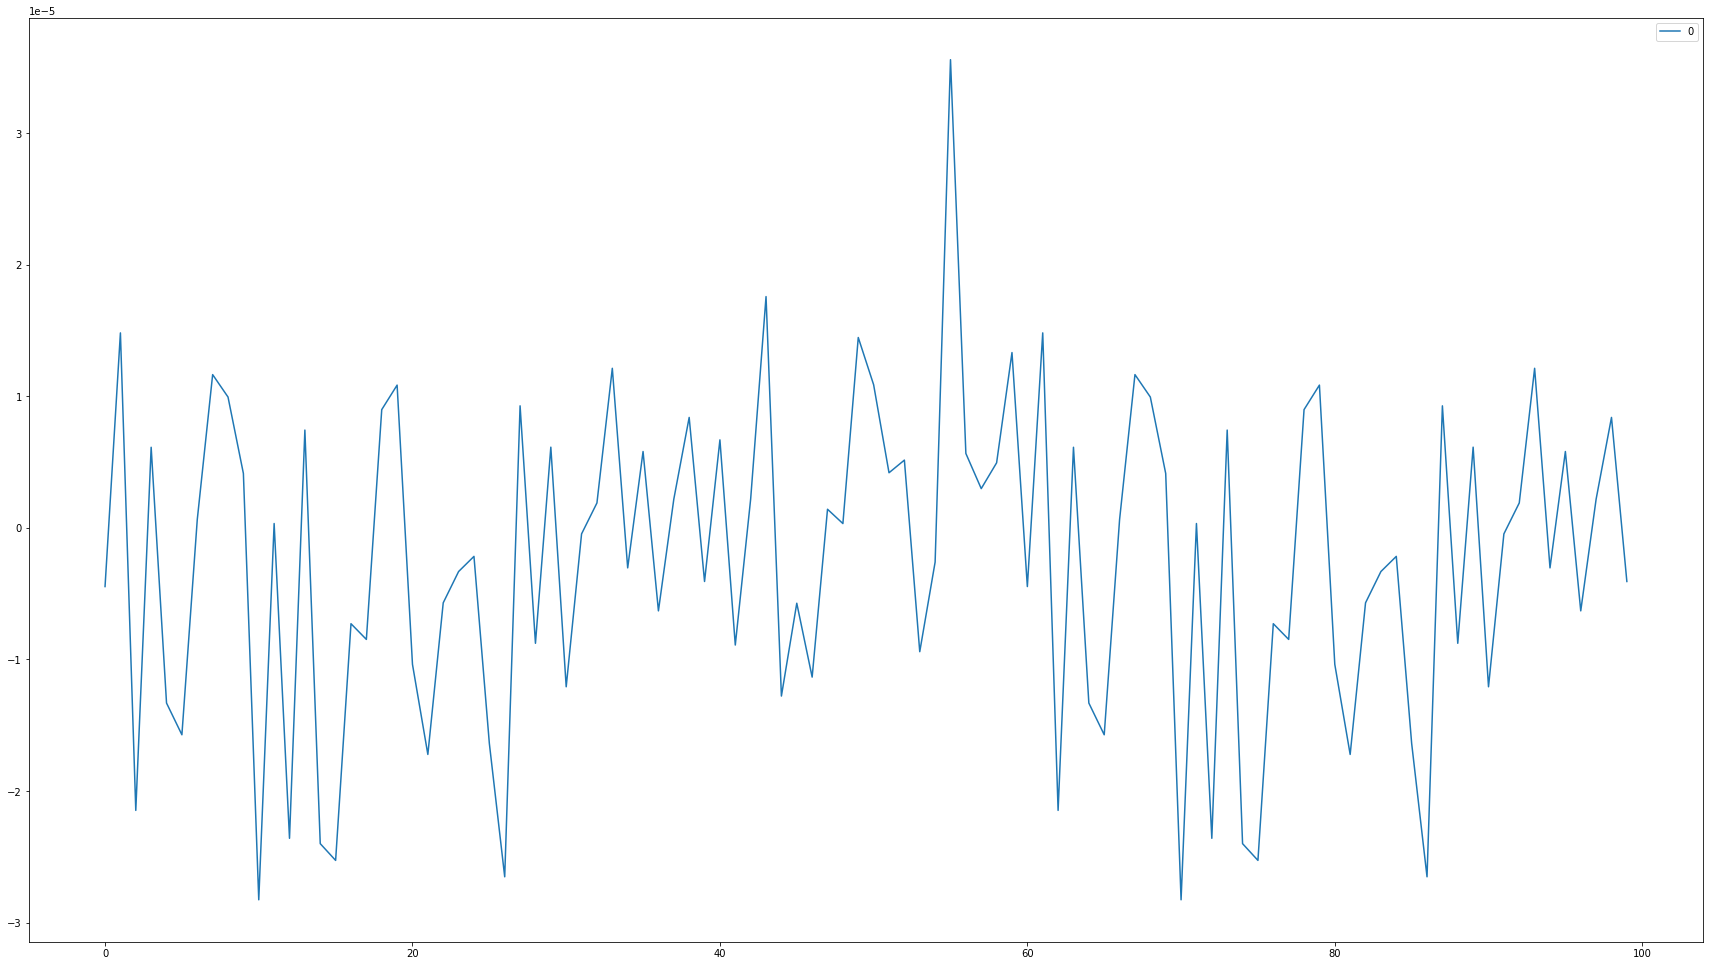

In [80]:
pd.DataFrame(data=npoutput[-100:]).plot(figsize=(30, 17))